In [2]:
import numpy as np
from sklearn.linear_model import LinearRegression
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import t, f, norm

In [3]:
alpha = 0.05

In [4]:
data = {'group': [1, 2, 3, 4, 5],
        'ig': [[83, 85],
               [84, 85, 85, 86, 86, 87],
               [86, 87, 87, 87, 88, 88, 88, 88, 88, 89, 90],
               [89, 90, 90, 91],
               [90, 92]]}

df = pd.DataFrame(data=data)
df

,group,ig
0,1,"[83, 85]"
1,2,"[84, 85, 85, 86, 86, 87]"
2,3,"[86, 87, 87, 87, 88, 88, 88, 88, 88, 89, 90]"
3,4,"[89, 90, 90, 91]"
4,5,"[90, 92]"


In [5]:
y_temp = np.concatenate(data['ig']).flatten().reshape(1, -1).T
y = y_temp.ravel()
n = np.size(y)
groups_count = len(data['group'])
PSI_preparation = []
for i, group in enumerate(data['ig']):
        tmp = [1 if j == i else 0 for j in range(groups_count)]
        for _ in range(len(group)):
            PSI_preparation.append(tmp)
# print(PSI_preparation)
sample = np.hstack((PSI_preparation, y_temp))
# print(sample)
X = sample[:, :-1]

## Определение влияния возраста на содержание иммуноглобулина в крови с помощью регрессионного анализа

In [6]:
F = X.T @ X
F_inv = np.linalg.inv(F)

b = F_inv @ X.T @ y
print('Полученные оэффициенты', *np.round(b, 2))

# model = LinearRegression(fit_intercept=False)
# model.fit(X, y)

# Create a pandas DataFrame to display the coefficients
# coefficients_df = pd.DataFrame({'My Coefficients': np.round(b, 1), 'Sklearn coefficients': np.round(model.coef_, 1)})
# coefficients_df

Полученные оэффициенты 84.0 85.5 87.82 90.0 91.0


### Значимость коэффициентов

In [7]:
y_pred = b @ X.T
RSS = np.sum((y_pred - y) ** 2)
# print("RSS:", np.round(RSS, 2))

In [8]:
p = b.shape[0] # count of coefficients

deltas_sign = b / np.sqrt(RSS * F_inv.diagonal()) * np.sqrt(n - p)
p_value = 2 * (1 - t.cdf(np.abs(deltas_sign), n - p))

pd_df = pd.DataFrame({'Delta': np.round(deltas_sign, 2), 'p_value': p_value, 'Значимость' : p_value < alpha})
pd_df

,Delta,p_value,Значимость
0,110.45,0.0,True
1,194.72,0.0,True
2,270.80,0.0,True
3,167.36,0.0,True
4,119.65,0.0,True


### Значимость регрессии

In [9]:
TSS = np.sum((y - np.mean(y)) ** 2)
# print("TSS:", np.round(TSS))

In [28]:
R2 = (TSS - RSS) / TSS
print("R^2:", np.round(R2, 3))

R^2: 0.811


In [11]:
delta = R2 / (1 - R2) * (n - p) / (p - 1)
print("delta:",np.round(delta, 2))

p_value = f.cdf(-np.abs(delta), p - 1, n - p) + (1 - f.cdf(np.abs(delta), p - 1, n - p))
print("p_value:", p_value)
if (p_value < alpha):
    print("Регрессия значима")
else:
    print("Регрессия не значима")

delta: 21.4
p_value: 5.407435041959729e-07
Регрессия значима


### Случайность выборки

In [12]:
errors = y_pred - y

In [13]:
def merge_sort(arr):
    """
    Funciton which calculates count of invertions and sorts an array
    """
    # Helper function to merge two sorted arrays and count inversions
    def merge(left, right):
        merged = []
        count = 0
        i = j = 0

        while i < len(left) and j < len(right):
            if left[i] <= right[j]:
                merged.append(left[i])
                i += 1
            else:
                # Element from the right array is smaller, so it's an inversion
                merged.append(right[j])
                count += len(left) - i
                j += 1

        merged.extend(left[i:])
        merged.extend(right[j:])
        
        return merged, count

    if len(arr) <= 1:
        return arr, 0

    mid = len(arr) // 2
    left, inv_left = merge_sort(arr[:mid])
    right, inv_right = merge_sort(arr[mid:])

    merged, count = merge(left, right)

    return merged, count + inv_left + inv_right

In [14]:
errors_sorted, inversion_count = merge_sort(errors)
print("Число инверсий:", inversion_count)

Число инверсий: 162


In [15]:
delta = (inversion_count - n * (n - 1) / 4) * np.sqrt(36 / n**3)
print("delta:", np.round(delta, 2))

p_value = 2 * norm.pdf(np.abs(delta), 0, 1)
print("p-value:", np.round(p_value, 2))
if (p_value < alpha):
    print("Выборка не случайная")
else:
    print("Выборка случайная")

delta: 0.58
p-value: 0.68
Выборка случайная


### Randominess of errors

In [16]:
# Number of bootstrap samples
n_samples = 1000

In [17]:
# Calculate the empirical function (CDF)
F_n = np.arange(1, n + 1) / n

# Plot the empirical function
# plt.step(errors_sorted, F_n, where='post')
# plt.title('Empirical Function of the Distribution')
# plt.xlabel('Data')
# plt.ylabel('Probability')
# plt.show()

In [18]:
# Generate bootstrap samples and calculate the delta for each sample
def delta(sample):    
    global F_n, n
    delta = np.sqrt(n) * np.max(np.abs(F_n - norm.pdf(sample, 0, np.var(sample))))
    return delta


deltas = np.array([delta(np.random.choice(errors, size=n, replace=True)) for _ in range(n_samples)])
print("Средне-арифметическое значение бутстрапа:", np.round(deltas.mean(), 2))

wave_delta = delta(errors)
print("Значение дельта с волной:", np.round(wave_delta, 2))

Средне-арифметическое значение бутстрапа: 4.08
Значение дельта с волной: 3.8


In [19]:
p_value = np.sum(deltas >= wave_delta) / n_samples
print("p-value:", np.round(p_value, 2))
if (p_value < alpha):
    print("Errors do not have normal distribution")
else:
    print("Errors have normal distribution")

p-value: 0.74
Errors have normal distribution


### Наличие выбросов

Count of outliers: 0
Outliers: []


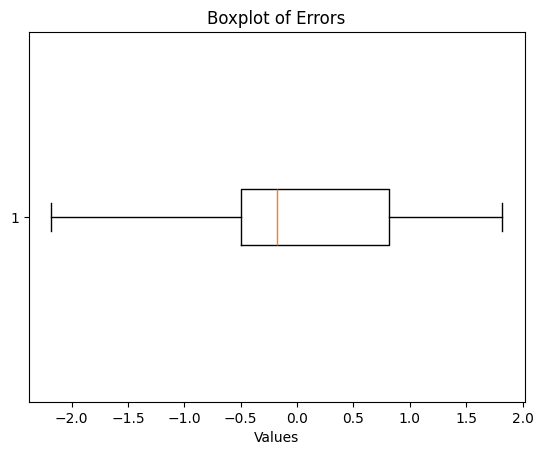

In [20]:
# Create a figure and axis
fig, ax = plt.subplots()

# Create a boxplot with the random data
boxplot = ax.boxplot(errors, vert=False)

outliers = boxplot['fliers'][0].get_data()[0]

# Count the outliers
outliers_count = len(outliers)
print("Count of outliers:", outliers_count)
print("Outliers:", np.round(outliers, 2))

# Set labels and title
ax.set_xlabel('Values')
ax.set_title('Boxplot of Errors')

# Show the plot
plt.show()

## Сравнение средних

In [26]:
p_values = np.full((p, p), 1, dtype=float)
equality = np.full((p, p), True)

F_inv_diag = np.diagonal(F_inv)
for i in range(p):
    for j in range(i + 1, p):
        delta = (b[i] - b[j]) / np.sqrt(RSS * (F_inv_diag[i] + F_inv_diag[j])) * np.sqrt(n - p)
        p_value = 2 * (1 - t(n - p).cdf(np.abs(delta)))
        p_values[j][i], p_values[i][j] = p_value, p_value

        if (p_value < alpha):
            equality[i][j], equality[j][i] = False, False
        else:
            equality[i][j], equality[j][i] = True, True
            

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
# ax1.set_title('Equality')
# ax2.set_title('p-values')
# print(equality)
print(np.round(p_values, 4))
# sns.heatmap(equality, annot=True, fmt='b', ax=ax1)
# sns.heatmap(np.round(p_values, 4), annot=True, ax=ax2)
# None

[[1.000e+00 1.031e-01 2.000e-04 0.000e+00 0.000e+00]
 [1.031e-01 1.000e+00 4.000e-04 0.000e+00 0.000e+00]
 [2.000e-04 4.000e-04 1.000e+00 2.400e-03 1.000e-03]
 [0.000e+00 0.000e+00 2.400e-03 1.000e+00 2.958e-01]
 [0.000e+00 0.000e+00 1.000e-03 2.958e-01 1.000e+00]]


In [27]:
print('[1, 2]', '[4, 5]')

[1, 2] [4, 5]
